%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}

</style>

## Missing Values - Multiple Imputation
<br>
<center>
<img src="../images/ibm-logo-bw.png" alt="ibm-logo" align="center" style="width: 200px;"/>
</center>

Complete case analysis and simple imputation are perhaps the most common ways to account for missing values in a data set.  Here we want to introduce multiple imputation and show how it can be built into your data analysis workflow.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import cprint
from IPython.display import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 11
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

def slide_print(text, color='white'):
    cprint(text, color, 'on_grey')

## Imputation

Why?

1. Commonly used libraries for machine learning require that their inputs have no missing values, and will not work if this requirement is not satisfied.  Algorithms that infer missing values are carrying out imputation.
2. Some incomplete data may be both useful and valuable

How?

* Simple imputation vs multiple imputation 
* Univariate vs multivariate imputation


Machine learning algorithms implemented in scikit-learn and other similar libaries assume that all values are filled in and they hold meaning. Another reason to consider imputation is that data is precious.  It could be precious either in terms of training data or in terms of cost to obtain.  Either way if we can use the incomplete data we should.  A common approach such as using the mean of a given feature is an example of univariate imputation.  Also because imputation was carried out only once it is a simple imputation.  Multivariate imputations use additional features and multiple imputations iterate over several possible imputation scenarios.

### Multiple imputation

>The practice of imputing missing values introduces <span style="color:orange">uncertainty</span> into the results of a data science project. One way to deal with that additional uncertainty is to try a range of different values for imputation and measure how the results vary between the different datasets.

scikit-learn has an [IterativeImputer](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) that can be used to carry out multiple imputations.  It is based on the `mice` package from R.

<small>Stef van Buuren, Karin Groothuis-Oudshoorn (2011). “mice: Multivariate Imputation by Chained Equations in R”. Journal of Statistical Software 45: 1-67.</small>

READ DEF.  scikit-learn has an IterativeImputer tool for modeling missing values. It can be called repeatedly to generate a number of different datasets with varying imputed values. Then, later in your data science workflow after settling on a particular modeling pipeline, you would use these different datasets as inputs and evaluate how the outputs from your pipeline differ depending on the missing value imputations used.  This tool is based on the well-known package mice from R. **END OF PART 1**

### The data

Lets say that you were starting with AAVAIL data shown below, but some missing values are not a regular part of this this dataset---specifically we are missing the `is_subscriber` values for a number of customers.

<br></br>

In [2]:
data_dir = os.path.join("..","data")
df = pd.read_csv(os.path.join(data_dir,r"aavail-target.csv"))
df.head()

,customer_id,is_subscriber,country,age,customer_name,subscriber_type,num_streams
0,1,1,united_states,21,Kasen Todd,aavail_premium,23
1,2,0,singapore,30,Ensley Garza,aavail_unlimited,12
2,3,0,united_states,21,Lillian Carey,aavail_premium,22
3,4,1,united_states,20,Beau Christensen,aavail_basic,19
4,5,1,singapore,21,Ernesto Gibson,aavail_premium,23


While it may be beneficial try the IterativeImputer when working with a dataset with a lot of inter-related missing values across several features, it is important that you know how to build your own multivariate imputer.  Then it is just a matter of using function calls to create multiple imputed datasets.

Recall the AAVAIL that were compiled during data ingestion.  In this example we will impute missing values from the 'is_subscriber' column.

In [3]:
from sklearn.preprocessing import OneHotEncoder

## one hot encode the subscriber
ohe1 = OneHotEncoder()
column = df['subscriber_type'].values.reshape(-1,1)
ohe1.fit(column)
labels1 = ohe1.categories_[0].tolist()
X1 = ohe1.transform(column).toarray()

## one hot encode the country
ohe2 = OneHotEncoder()
column = df['country'].values.reshape(-1,1)
ohe2.fit(column)
labels2 = ohe2.categories_[0].tolist()
X2 = ohe2.transform(column).toarray()

## concat all of the data
labels = ['is_subscriber','age','num_streams']
X = df.loc[:,labels].to_numpy()
labels = labels + labels1 + labels2
X = np.hstack([X,X1,X2])
df1 = pd.DataFrame({label:X[:,i] for i,label in enumerate(labels)})

df1.head()

,is_subscriber,age,num_streams,aavail_basic,aavail_premium,aavail_unlimited,singapore,united_states
0,1.0,21.0,23.0,0.0,1.0,0.0,0.0,1.0
1,0.0,30.0,12.0,0.0,0.0,1.0,1.0,0.0
2,0.0,21.0,22.0,0.0,1.0,0.0,0.0,1.0
3,1.0,20.0,19.0,1.0,0.0,0.0,0.0,1.0
4,1.0,21.0,23.0,0.0,1.0,0.0,1.0,0.0


Here we use one hot encoding to expand the 'country' and 'subscriber_type' columns.  We also include the other features that might be useful for imputing the missing values.

## Add missing values

<br></br>

In [4]:
# Set a portion (of size num_nulls) of the data to NaN
print(X.shape)
np.random.seed(0)
num_nulls = 50
null_rows = np.random.choice(X.shape[0], size = num_nulls, replace = False)
null_col = [0]*num_nulls
known_missing = X[null_rows, null_col].copy()
X[null_rows, null_col] = np.nan

# Check where the NaNs are:
print(np.isnan(X).sum(axis = 0))

(1000, 8)
[50  0  0  0  0  0  0  0]


This is an educational exercise and for this reason we are showing you how to add missing values to these data.  Adding missing values to a dataset to better understand the effects of imputation methods is a useful tool.  Think of this example and code as a sandbox or as a template for other data sets when exploring new imputation methods.

In [5]:
def make_corr_plot(df,columns):
    """
    make a pairwise correlation plot
    """

    # Compute the correlation matrix
    corr = df[columns].corr()
    #corr = np.corrcoef(X.T)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 7),dpi=150,facecolor='white')

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


In order for this to work there needs to be a relationship between the features.  We can plot the pairwise correlations  as a grid to better understand whether or not this is a reasonable assumption.  **END OF PART 2**

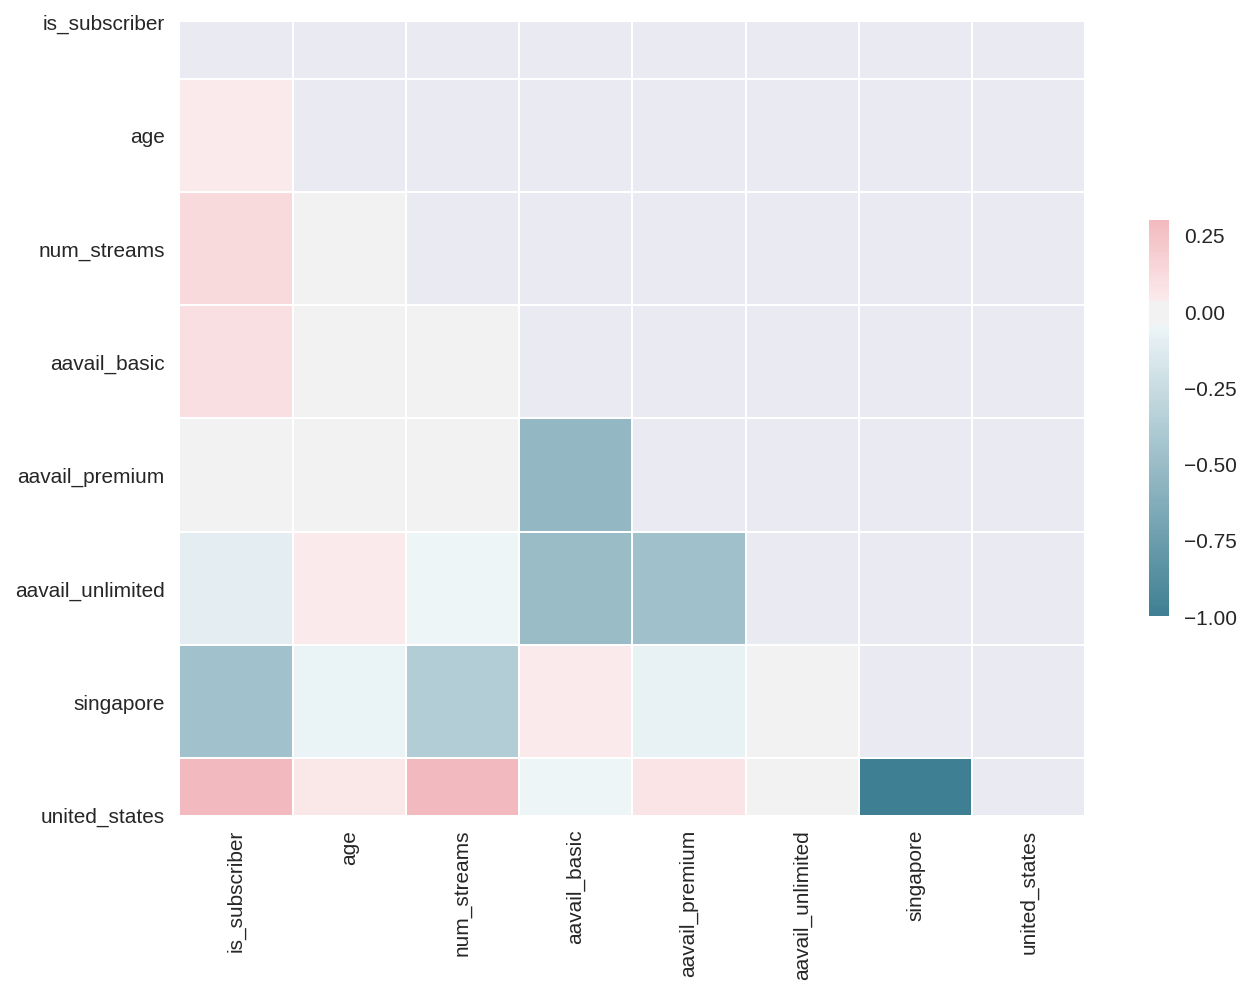

In [6]:
make_corr_plot(df1,labels)

Remember that before we view a plot we should think about what we expect as a habit for quality assurance.  Before we visualized this plot we *expected* that subscribers from singapore would be negatively correlated with being a subscriber.

In [7]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

## variables
impute_col = 0
C = 0.01

## identify the values that can be used as features
y_impute = X[:, impute_col].copy()
X_impute = X[:, np.setdiff1d(np.arange(X.shape[1]),impute_col)].copy()
missing = np.isnan(y_impute)

## scale using sklearn
scaler = preprocessing.StandardScaler().fit(X_impute)
X_impute =  scaler.transform(X_impute)

mod1 = LogisticRegression(C=C)
mod1.fit(X_impute[~missing], y_impute[~missing])
predicted_missing = mod1.predict(X_impute[missing])
slide_print(classification_report(known_missing, predicted_missing, target_names=['inactive','subscriber']))

X1 = X.copy()
X1[missing,impute_col] = predicted_missing

              precision    recall  f1-score   support

    inactive       0.39      0.44      0.41        16
  subscriber       0.72      0.68      0.70        34

    accuracy                           0.60        50
   macro avg       0.55      0.56      0.55        50
weighted avg       0.61      0.60      0.61        50



Here we use logistic regression to 'impute' the missing values in column 1.  The other columns are used as predictors.  The parameter 'C' is the inverse of the regularization strength and it must must be a positive float. Like in support vector machines, smaller values specify stronger regularization. The f1-scores are something that we could be improve on, but with real data you would not even know this, unless you performed an experiment like this one.  Feel free to use another model in place of logistic regression to see if you can improve on the predictive performance.  The important thing here is that there is the regularization parameter that we can change to allow for multiple imputations.

In [8]:
datasets = []
for C in [0.0001, 0.1, 0.5]:
    mod1 = LogisticRegression(C=C)
    mod1.fit(X_impute[~missing], y_impute[~missing])
    predicted_missing = mod1.predict(X_impute[missing])
    slide_print(classification_report(known_missing, predicted_missing, target_names=['inactive','subscriber']))

    X_new = X.copy()
    X_new[missing,impute_col] = predicted_missing
    datasets.append(X_new)

              precision    recall  f1-score   support

    inactive       0.39      0.44      0.41        16
  subscriber       0.72      0.68      0.70        34

    accuracy                           0.60        50
   macro avg       0.55      0.56      0.55        50
weighted avg       0.61      0.60      0.61        50

              precision    recall  f1-score   support

    inactive       0.33      0.31      0.32        16
  subscriber       0.69      0.71      0.70        34

    accuracy                           0.58        50
   macro avg       0.51      0.51      0.51        50
weighted avg       0.57      0.58      0.58        50

              precision    recall  f1-score   support

    inactive       0.29      0.25      0.27        16
  subscriber       0.67      0.71      0.69        34

    accuracy                           0.56        50
   macro avg       0.48      0.48      0.48        50
weighted avg       0.54      0.56      0.55        50



Here we have generated the new data sets. Some number between 3 and 10 versions is usually sufficient to ensure that you have an understanding of the variability associated with your imputation strategy.  By removing data and carrying out imputation you now have an additional tool to compare strategies without proceeding all the way through the workflow.